In [188]:
import numpy as np
import scipy as sp
from constrained_linear_regression import ConstrainedLinearRegression
from sklearn.linear_model import LinearRegression

# Load Jacobian, residual, and bounds data

In [197]:
square_jac = np.load("../synthetic_data/square_jacobian.npy")
square_res = np.load("../synthetic_data/square_residual.npy")

print(f" Jacobian shape: {np.shape(square_jac)}")
print(f" Residual shape: {np.shape(square_res)}")

 Jacobian shape: (4941, 4941)
 Residual shape: (4941,)


In [198]:
non_square_jac = np.load("../synthetic_data/non_square_jacobian.npy")
non_square_res = np.load("../synthetic_data/non_square_residual.npy")

print(f" Jacobian shape: {np.shape(non_square_jac)}")
print(f" Residual shape: {np.shape(non_square_res)}")

 Jacobian shape: (1271, 4941)
 Residual shape: (1271,)


# Test various solvers with square data

In [203]:
jacobian = copy.deepcopy(square_jac)
residuals = copy.deepcopy(square_res)

In [221]:
solvers = [
    "verde least squares",
    "scipy least squares",
    "scipy constrained",
    "scipy nonlinear lsqr",
    "CLR",
    "scipy conjugate",
    "numpy least squares",
    "steepest descent",
    "gauss newton",
]

UnboundLocalError: local variable 'step' referenced before assignment

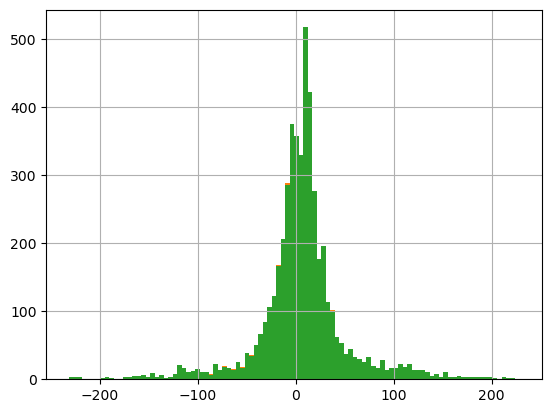

In [223]:
for s in solvers:
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=None,
    )
    pd.Series(step).hist(bins=100)

<AxesSubplot: >

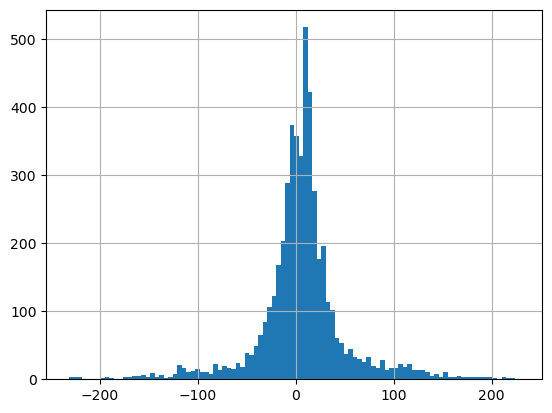

In [205]:
# scipy least squares
step = sp.sparse.linalg.lsqr(
    A=jacobian.copy(),
    b=residuals.copy(),
    show=False,
    damp=0,  # float, typically 0-1
)[0]
pd.Series(step).hist(bins=100)

<AxesSubplot: >

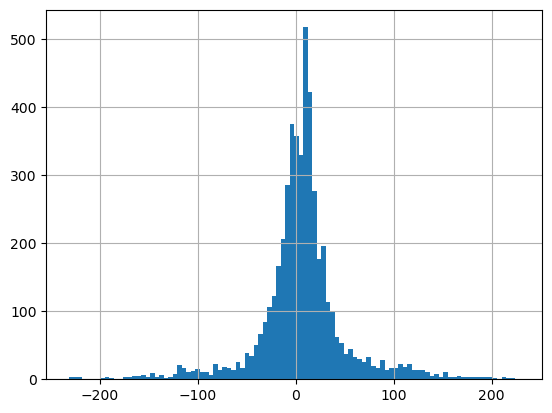

In [206]:
# scipy constrained - unbounded
step = sp.optimize.lsq_linear(
    A=jacobian.copy(),
    b=residuals.copy(),
    method="trf",
)["x"]
pd.Series(step).hist(bins=100)

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.7524e+03                                    3.08e+01    
       1         7.6274e+02      9.90e+02       6.37e+02       4.88e+00    
       2         4.3764e+02      3.25e+02       3.31e+02       1.07e+00    
       3         2.9293e+02      1.45e+02       5.25e+02       2.10e-01    
       4         2.6051e+02      3.24e+01       4.07e+02       2.27e-01    
The maximum number of iterations is exceeded.
Number of iterations 5, initial cost 1.7524e+03, final cost 2.5730e+02, first-order optimality 2.27e-01.


<AxesSubplot: >

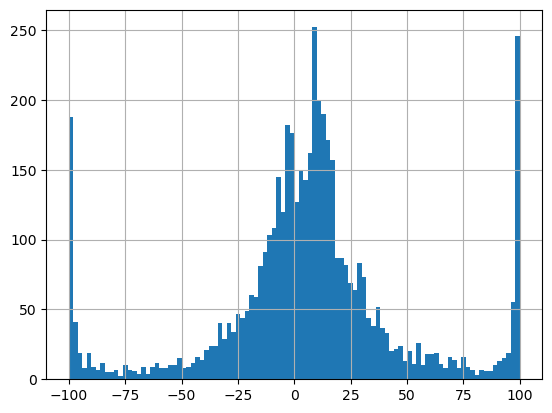

In [207]:
# scipy constrained - bounded
step = sp.optimize.lsq_linear(
    A=jacobian.copy(),
    b=residuals.copy(),
    bounds=[-100, 100],
    method="trf",
    max_iter=5,
    verbose=2,
)["x"]
pd.Series(step).hist(bins=100)

THE MODEL DID NOT CONVERGE


<AxesSubplot: >

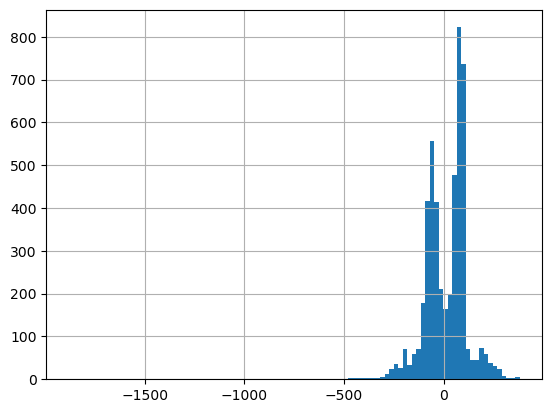

In [208]:
# CLR - unbounded
model = ConstrainedLinearRegression(
    max_iter=10,
    ridge=None,
    # fit_intercept=False,
)
step = model.fit(
    X=jacobian.copy(),
    y=residuals.copy(),
).coef_
pd.Series(step).hist(bins=100)

THE MODEL DID NOT CONVERGE


<AxesSubplot: >

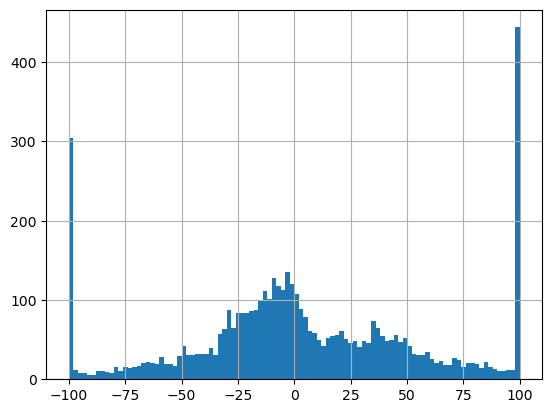

In [209]:
# CLR - bounded
model = ConstrainedLinearRegression(
    max_iter=10,
    ridge=None,
    # fit_intercept=False,
)
step = model.fit(
    X=jacobian.copy(),
    y=residuals.copy(),
    min_coef=np.repeat(-100, jacobian.shape[1]),
    max_coef=np.repeat(100, jacobian.shape[1]),
).coef_
pd.Series(step).hist(bins=100)

<AxesSubplot: >

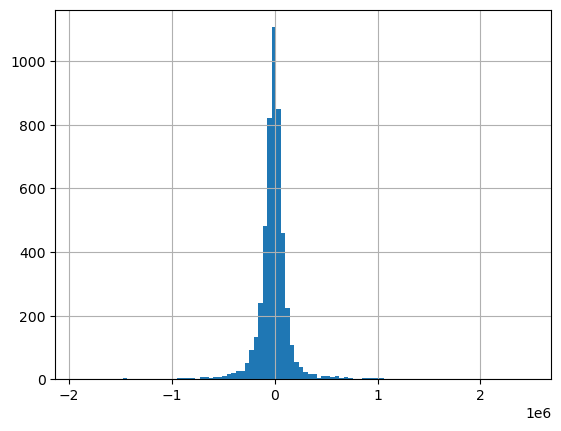

In [210]:
# scipy conjugate gradient
step = sp.sparse.linalg.cg(
    jacobian.copy(),
    residuals.copy(),
)[0]
pd.Series(step).hist(bins=100)

<AxesSubplot: >

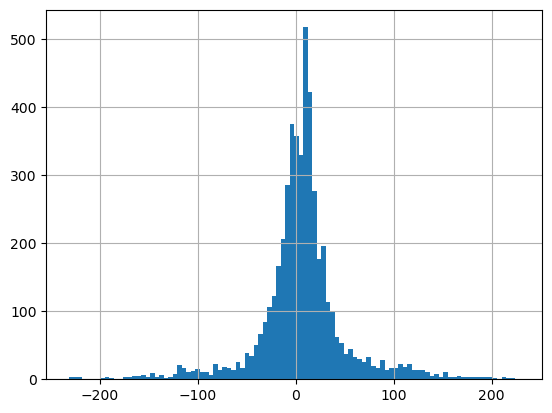

In [212]:
# numpy least squares
step = np.linalg.lstsq(
    jacobian.copy(),
    residuals.copy(),
)[0]
pd.Series(step).hist(bins=100)

<AxesSubplot: >

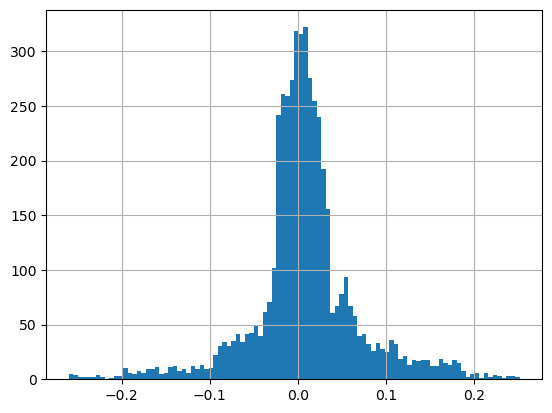

In [214]:
# steepest descent
jacobian = jacobian.copy()

step = jacobian.T @ residuals

pd.Series(step).hist(bins=100)

<AxesSubplot: >

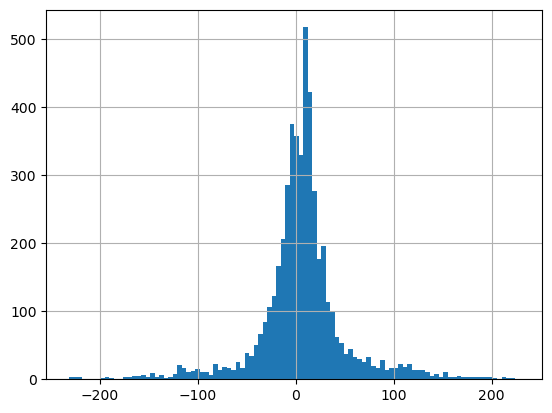

In [215]:
# Gauss Newton w/ 1st order Tikhonov regularization
jacobian = jacobian.copy()

fdmatrix = inv.finite_difference_matrix(jacobian[1].size)

damping = 0

if damping in [None, 0]:
    hessian = jacobian.T @ jacobian
    gradient = jacobian.T @ residuals
else:
    fdmatrix = inv.finite_difference_matrix(jac[1].size)
    hessian = (jacobian.T @ jacobian) + damping * (fdmatrix.T @ fdmatrix)
    gradient = (jacobian.T @ residuals) - damping * (
        fdmatrix.T @ fdmatrix @ prisms_df.surface
    )

step = np.linalg.solve(hessian, gradient)
pd.Series(step).hist(bins=100)